# In Game -  Classification Models and Hyperparameter Finetuning

In [18]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier
)
from sklearn.svm import SVC
from xgboost import XGBClassifier


### path and file

In [19]:
path = r"C:\Users\eitanb\Documents\GitHub\ML_Football_DS18\DATA"
path_result = r"C:\Users\eitanb\Documents\GitHub\ML_Football_DS18\result"

In [20]:
#importing model data
df_model=pd.read_csv(path_result+"/"+'model_after_feature_selection_prediction_during_game.csv', index_col=0)

### Split the data to tarin 80% and test 20% 

In [21]:
# Ensure the target column 'result' exists in the dataset
if 'result' in df_model.columns:
    # Define target
    y = df_model['result']
    
    # Define features by dropping the target column
    X = df_model.drop(columns=['result'])

    # Split into train and test sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )

    # Show the shapes of the resulting sets
    split_shapes = {
        "X_train": X_train.shape,
        "X_test": X_test.shape,
        "y_train": y_train.shape,
        "y_test": y_test.shape
    }
else:
    split_shapes = "❌ Column 'result' not found in dataset."

split_shapes


{'X_train': (10144, 27),
 'X_test': (2536, 27),
 'y_train': (10144,),
 'y_test': (2536,)}

### model run throw 8 calssification model  

In [22]:

# Classification metrics function
def classificationMetrics(y_true, y_pred, y_proba=None):
    precision, recall, f1, _ = metrics.precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )

    result = {
        'Accuracy': metrics.accuracy_score(y_true, y_pred),
        'Precision': precision,
        'Recall': recall,
        'f1-score': f1
    }

    if y_proba is not None:
        try:
            result['Log-loss'] = metrics.log_loss(y_true, y_proba)
            result['AUC'] = metrics.roc_auc_score(y_true, y_proba, multi_class='ovr')
        except:
            result['Log-loss'] = None
            result['AUC'] = None
    else:
        result['Log-loss'] = None
        result['AUC'] = None

    return result


In [23]:
def get_feature_importance(model, feature_names):
    """
    Returns a sorted list of (feature_name, importance) tuples for a fitted model.
    
    Supports both tree-based models and linear models.
    """
    try:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = model.coef_[0]  # for binary classification
        else:
            return None

        feature_importance = list(zip(feature_names, importances))
        return sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)
    except Exception:
        return None


### models run summarize

In [24]:


models_list = pd.DataFrame()
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("AdaBoost", AdaBoostClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
    ("SVM", SVC(probability=True)),
    ("Extra Trees", ExtraTreesClassifier())
]

# Store metrics and confusion matrices
models_list = pd.DataFrame()
confusion_matrices = {}
importance_feature={}
importance_rows = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    try:
        y_proba = model.predict_proba(X_test)
    except:
        y_proba = None

    # Metrics
    model_dict = {'Model': name}
    metrics_dict = classificationMetrics(y_test, y_pred, y_proba)
    row = pd.DataFrame([{**model_dict, **metrics_dict}])
    models_list = pd.concat([models_list, row], ignore_index=True)

    # Confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    confusion_matrices[name] = cm

    # importence features by model
    # Feature importance
    importance_feature[name] = get_feature_importance(model, X_train.columns)

models_list


,Model,Accuracy,Precision,Recall,f1-score,Log-loss,AUC
0,Logistic Regression,0.735410,0.703540,0.699153,0.699561,0.599469,0.882633
1,Decision Tree,0.697555,0.670066,0.668959,0.669296,10.901215,0.758191
2,Random Forest,0.761041,0.733966,0.726534,0.727060,0.577282,0.904852
3,AdaBoost,0.732650,0.708296,0.701302,0.703917,1.028839,0.845061
4,Gradient Boosting,0.785095,0.763748,0.760332,0.761825,0.493974,0.925151
5,XGBoost,0.820978,0.801544,0.794263,0.796709,0.430875,0.942299
6,SVM,0.436909,0.145636,0.333333,0.202708,0.885642,0.754000
7,Extra Trees,0.778391,0.753902,0.743540,0.743593,0.568479,0.911862


#### saving best model (XGBoost) as pickle file for future implication

In [26]:
import pickle

# Save XGBoost model
xgb_model = dict(models)["XGBoost"]
with open(path_result+"/"+"best_model_xgboost_In_Game_prediction.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

### confusion matrix for every model

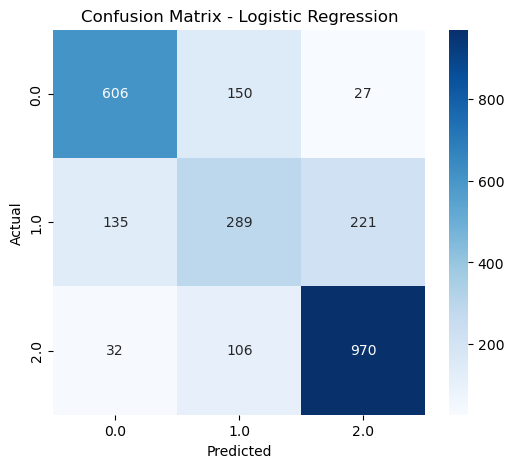

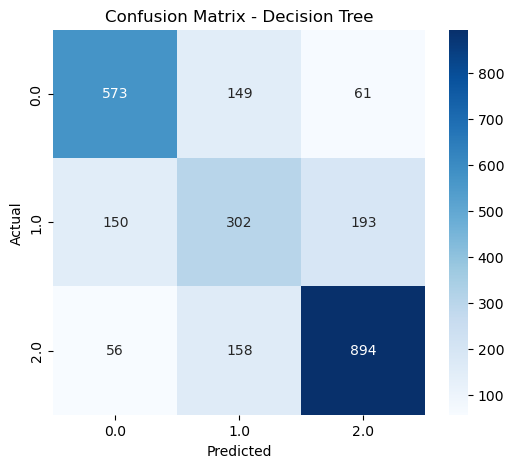

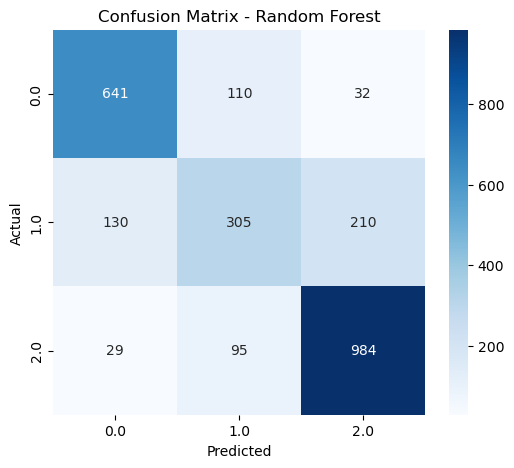

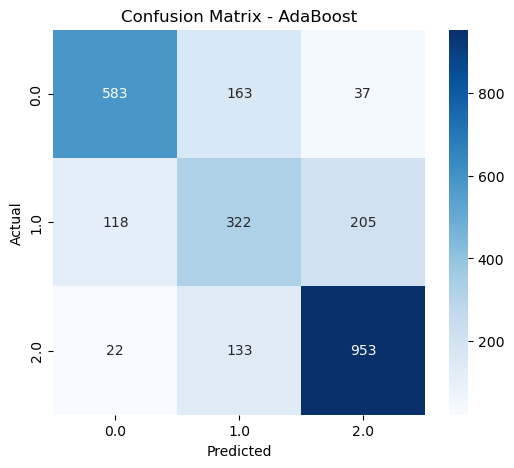

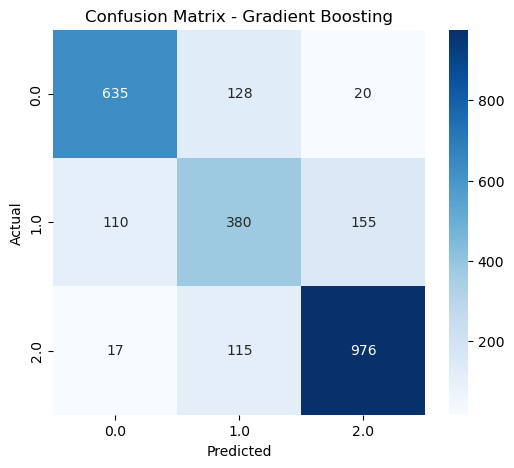

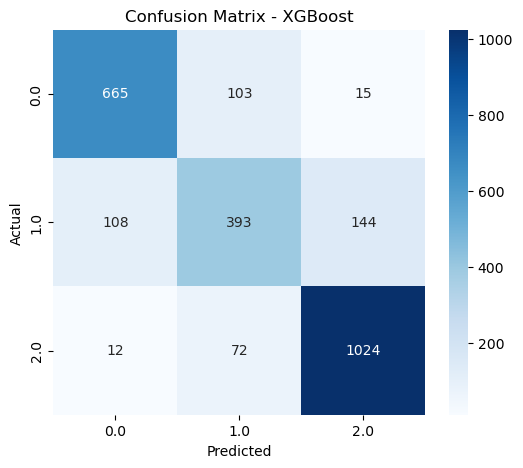

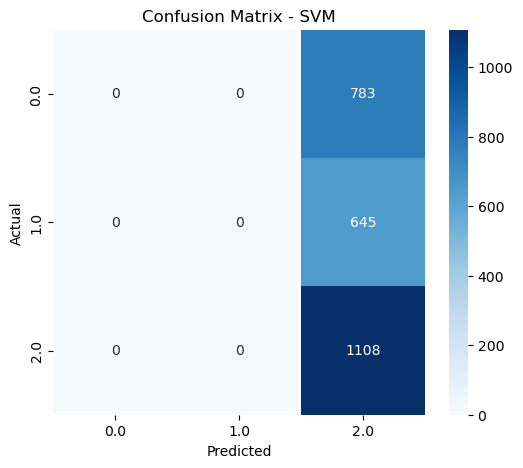

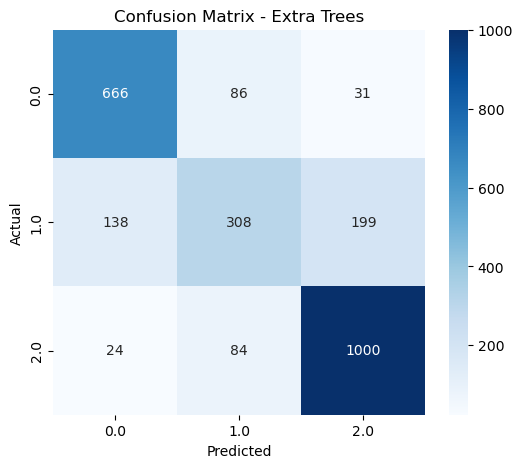

In [27]:
def plot_confusion_matrix(cm, labels, title="Confusion Matrix"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()
labels = sorted(y_test.unique())  # Get sorted class labels from your y_test

for model_name in models_list['Model']:
    conf_m = confusion_matrices.get(model_name)
    if conf_m is not None:
        plot_confusion_matrix(conf_m, labels, title=f"Confusion Matrix - {model_name}")
    else:
        print(f"No confusion matrix found for {model_name}")


### importance features by model

In [28]:
importance_df = pd.DataFrame(importance_feature)
importance_df

,Logistic Regression,Decision Tree,Random Forest,AdaBoost,Gradient Boosting,XGBoost,SVM,Extra Trees
0,"(total_assists_a_cat, 1.1299950273882498)","(total_assists_a_cat, 0.23578945427348164)","(total_assists_h_cat, 0.1439942835727374)","(total_assists_h_cat, 0.3662438342668996)","(total_assists_a_cat, 0.375644390364227)","(total_assists_h_cat, 0.2594238)",None,"(total_assists_h_cat, 0.14781769607509454)"
1,"(total_assists_h_cat, -0.8837214352375264)","(total_assists_h_cat, 0.20681934199285135)","(total_assists_a_cat, 0.1343959013756988)","(total_assists_a_cat, 0.26598404343347)","(total_assists_h_cat, 0.37465637366094284)","(total_assists_a_cat, 0.24836856)",None,"(total_assists_a_cat, 0.1431505926530166)"
2,"(shotsOnTarget_a, 0.525500992713608)","(xGoals_h, 0.05839318110162902)","(total_xGoalsChain_a, 0.06515264542576281)","(xGoals_h, 0.10020186407144176)","(shotsOnTarget_h, 0.05444237105246381)","(shotsOnTarget_h, 0.042144846)",None,"(shotsOnTarget_h, 0.056814283397938856)"
3,"(shotsOnTarget_h, -0.41682685279889475)","(xGoals_a, 0.04385588866520136)","(total_xGoalsChain_h, 0.05579306698810452)","(shotsOnTarget_h, 0.07391499618071246)","(shotsOnTarget_a, 0.04468477478286234)","(shotsOnTarget_a, 0.041829374)",None,"(shotsOnTarget_a, 0.05123110450225214)"
4,"(total_saved_shots_a, -0.19400397291757343)","(total_xGoalsChain_a, 0.03298351262043724)","(xGoals_a, 0.05506945472762721)","(shotsOnTarget_a, 0.07033938508775675)","(xGoals_h, 0.03304911053119332)","(total_saved_shots_h, 0.04070302)",None,"(xGoals_h, 0.04710979687214695)"
5,"(xGoals_h, -0.1758426427164255)","(total_xGoalsChain_h, 0.032142170725948306)","(xGoals_h, 0.054465213689096084)","(xGoals_a, 0.06640212796202521)","(xGoals_a, 0.030381818589150872)","(total_saved_shots_a, 0.036916707)",None,"(xGoals_a, 0.04366129470647065)"
6,"(xGoals_a, 0.12214413227230388)","(shotsOnTarget_h, 0.03126576640813163)","(shotsOnTarget_h, 0.04761475194774424)","(total_xGoalsChain_a, 0.02401102432682619)","(total_saved_shots_h, 0.02113231524734555)","(xGoals_h, 0.031240836)",None,"(total_xGoalsChain_a, 0.03911620871819769)"
7,"(total_xGoalsChain_h, -0.11554305935535099)","(ppda_h, 0.030903083083285855)","(shotsOnTarget_a, 0.041332898599326665)","(total_saved_shots_a, 0.01764893027319371)","(total_saved_shots_a, 0.016431519621688744)","(xGoals_a, 0.02740247)",None,"(total_xGoalsChain_h, 0.03589705093319159)"
8,"(total_saved_shots_h, 0.10605616480309904)","(shotsOnTarget_a, 0.027630896769507012)","(ppda_h, 0.03111629255888823)","(total_key_passes_h, 0.015253794397674448)","(total_xGoalsChain_a, 0.009378035875367507)","(total_key_passes_a, 0.02136617)",None,"(total_saved_shots_h, 0.02950443390296439)"
9,"(total_xGoalsChain_a, 0.10403934342845288)","(ppda_a, 0.026331606469698385)","(ppda_a, 0.030256334871442782)","(season, 0.0)","(total_xGoalsChain_h, 0.006873918424462604)","(total_key_passes_h, 0.020969681)",None,"(total_saved_shots_a, 0.027283038005041185)"


## XGBoost provides the best results with 82% accuracy

### Hyperparameter Finetuning

In [29]:
%pip install --upgrade xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
import numpy as np

from xgboost import XGBClassifier

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    verbosity=0
)


from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define parameter space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'gamma': [0, 1, 5]}

# Set up randomized search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring=make_scorer(f1_score, average='macro'),
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run it!
random_search.fit(X_train, y_train)

# Get the best model and performance
best_xgb = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

print("✅ Best Parameters:", best_params)
print("🎯 Best F1 Score (CV):", best_score)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict on the test set
y_pred = best_xgb.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')  # use 'binary' for binary classification
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Store results
result = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'f1-score': f1
}

print("📊 Evaluation Metrics:")
for k, v in result.items():
    print(f"{k}: {v:.4f}")



Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ Best Parameters: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.7}
🎯 Best F1 Score (CV): 0.792757842253348
📊 Evaluation Metrics:
Accuracy: 0.8170
Precision: 0.7970
Recall: 0.7909
f1-score: 0.7928


### The best parameters result got lowe F1 score and accuracy then the defult result 